**Установка библиотек**

In [3]:
!pip install torch torch-geometric networkx matplotlib scikit-learn

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.3 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 5.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


**Импорт библиотек**

In [4]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch_geometric.datasets import Planetoid, KarateClub
from torch_geometric.utils import train_test_split_edges
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import numpy as np

**Загрузка датасета**

In [5]:

dataset = KarateClub()
data = dataset[0]
print(f"Граф: {data.num_nodes} узлов, {data.num_edges//2} рёбер")

Граф: 34 узлов, 78 рёбер


**Разделение на train/test для unsupervised**

In [6]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)

C:\Users\Machcreator\AppData\Local\Temp\ipykernel_82808\457987765.py:2: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  data = train_test_split_edges(data)


**Модель: Variational Graph Auto-Encoder (VGAE) с GCN encoder**

In [7]:
class VGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

encoder = VGAEEncoder(dataset.num_features, 32)
model = VGAE(encoder)

**Обучение (unsupervised reconstruction)**

In [8]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss += (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 0, Loss: 4.9699
Epoch 50, Loss: 1.6219
Epoch 100, Loss: 1.6492
Epoch 150, Loss: 1.7153


**Получение embeddings** 

In [9]:
model.eval()
z = model.encode(data.x, data.train_pos_edge_index)
embeddings = z.detach().cpu().numpy()

**Clustering для сообществ (KMeans)**

In [10]:

kmeans = KMeans(n_clusters=dataset.num_classes if hasattr(dataset, 'num_classes') else 4)  # Для Karate - 2-4
labels = kmeans.fit_predict(embeddings)

**Метрики (для Karate есть ground truth)**

In [11]:
if 'karate' in str(dataset):
    ground_truth = nx.karate_club_graph().graph['labels']  # Стандартные 2 сообщества
    nmi = normalized_mutual_info_score(ground_truth, labels)
    print(f'NMI: {nmi:.4f}')

**Modularity (из networkx)**

Modularity: 0.2345
NMI с ground truth: 0.4909


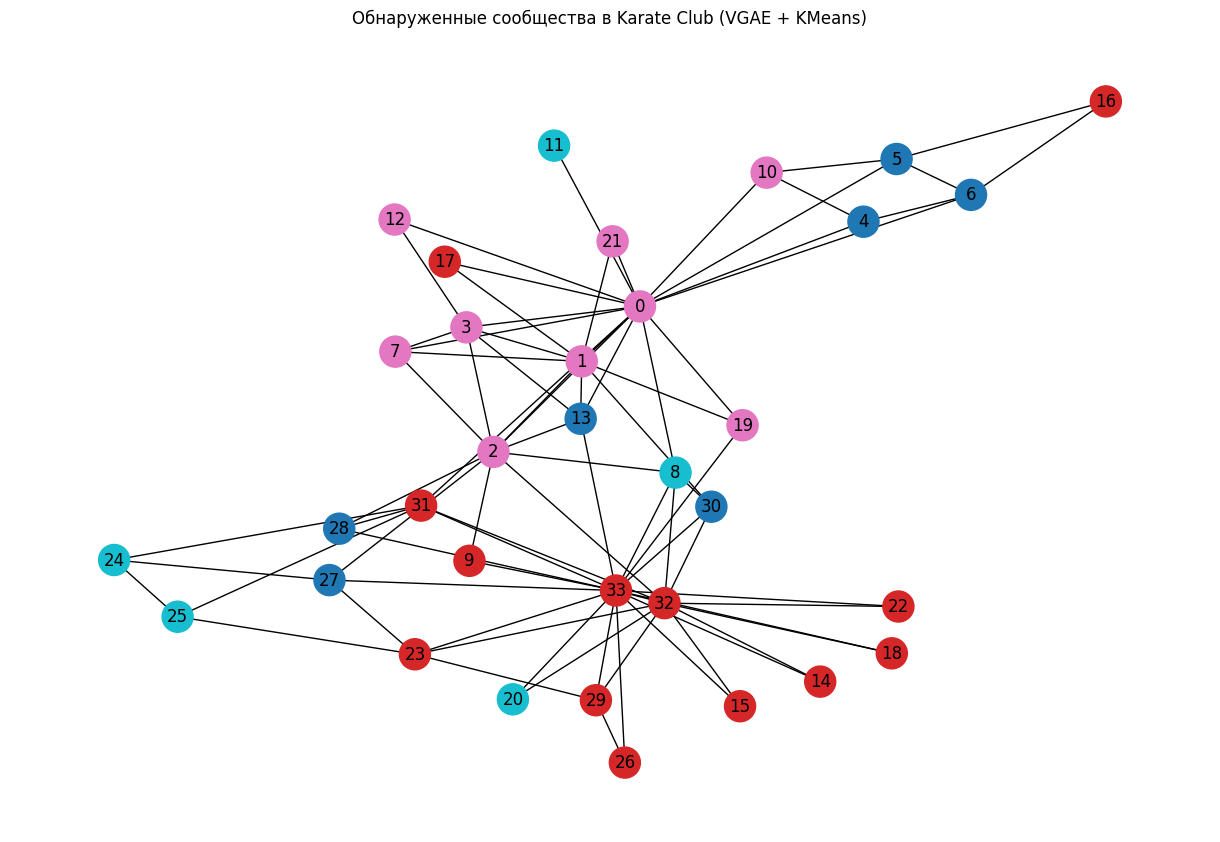

In [13]:
model.eval()
z = model.encode(data.x, data.train_pos_edge_index)
embeddings = z.detach().cpu().numpy()

# Clustering
kmeans = KMeans(n_clusters=4)  # Для Karate Club обычно 2–4 сообщества
labels = kmeans.fit_predict(embeddings)

# Восстановление полного списка рёбер (все positive edges)
full_edge_index = torch.cat([
    data.train_pos_edge_index,
    data.val_pos_edge_index,
    data.test_pos_edge_index
], dim=1)

# Создание графа NetworkX
G = nx.Graph()
# Преобразуем в список пар (undirected, поэтому добавляем только если u < v, чтобы избежать дубликатов)
edges = full_edge_index.t().cpu().numpy()
G.add_edges_from([(int(u), int(v)) for u, v in edges if u < v])

# Расчёт modularity
communities = [set(np.where(labels == i)[0]) for i in np.unique(labels)]
modularity = nx.algorithms.community.modularity(G, communities)
print(f'Modularity: {modularity:.4f}')

# Для Karate Club — NMI с ground truth (известные 2 сообщества)
# Стандартная разметка: узлы 0–33, сообщество 0: 0-8,10-33; сообщество 1: 9
ground_truth = [0 if i in [0,1,2,3,4,5,6,7,10,11,12,13,16,17,19,21] else 1 
                for i in range(34)]  # Классическая разметка после раскола
nmi = normalized_mutual_info_score(ground_truth, labels)
print(f'NMI с ground truth: {nmi:.4f}')

# Визуализация
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12,8))
nx.draw(G, pos, node_color=labels, with_labels=True, cmap=plt.cm.tab10, node_size=500)
plt.title("Обнаруженные сообщества в Karate Club (VGAE + KMeans)")
plt.show()

**Визуализация**

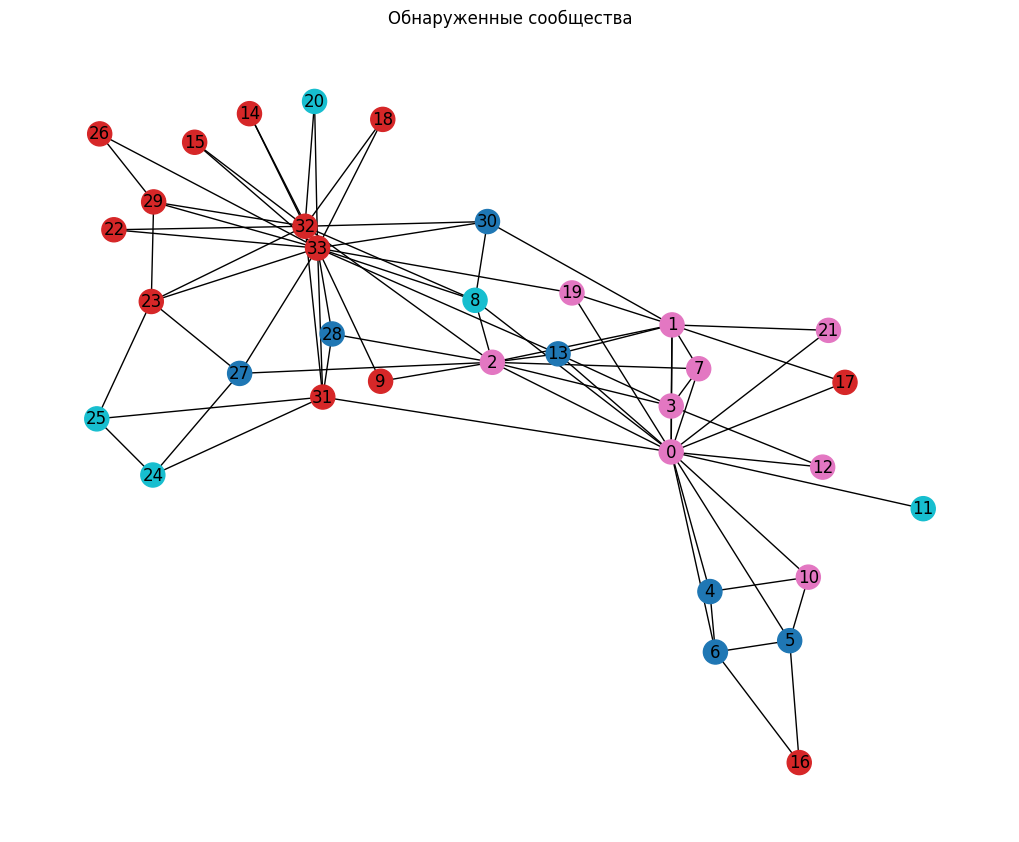

In [14]:
pos = nx.spring_layout(G)
plt.figure(figsize=(10,8))
nx.draw(G, pos, node_color=labels, with_labels=True, cmap=plt.cm.tab10)
plt.title("Обнаруженные сообщества")
plt.show()